<a href="https://colab.research.google.com/github/rajvirvyas/Senior-Project/blob/main/Custom_CNN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGLE_USR"] = userdata.get('KAGGLE_USR')

In [2]:
!kaggle datasets download -d marcozuppelli/stegoimagesdataset

! unzip -qq "stegoimagesdataset.zip"

Dataset URL: https://www.kaggle.com/datasets/marcozuppelli/stegoimagesdataset
License(s): DbCL-1.0
100% 1.51G/1.51G [01:20<00:00, 22.4MB/s]
100% 1.51G/1.51G [01:20<00:00, 20.2MB/s]


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 13 16:59:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   43C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy


import os
from sklearn.metrics import classification_report, confusion_matrix


#from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt


def weighted_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    loss = bce(y_true, y_pred)
    stego_weight = 2.0  # Penalize missing stego images more
    weighted_loss = tf.where(y_true == 1, loss * stego_weight, loss)
    return tf.reduce_mean(weighted_loss)



In [43]:
def create_custom_cnn(input_shape=(512, 512, 3)):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # output: 256x256x16


        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # output: 128x128x32


        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # output: 64x64x64


        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # output: 32x32x64


        Flatten(),  # output: 32*32*64 = 65536
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss=weighted_bce,
                 metrics=['accuracy'])
    return model


def create_data_generators(train_dir, val_dir, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.95, 1.05),  # Subtle changes
        channel_shift_range=2  # Slight color shifts
    )
    val_datagen = ImageDataGenerator(rescale=1./255,
        brightness_range=(0.95, 1.05),  # Subtle changes
        channel_shift_range=2  # Slight color shifts
    )


    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')
    val_generator = val_datagen.flow_from_directory(
        val_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')


    return train_generator, val_generator


def compute_class_weights(generator):
    class_counts = [0] * len(generator.class_indices)
    for i in range(len(generator.classes)):
        class_counts[generator.classes[i]] += 1

    total_samples = sum(class_counts)
    class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

    # Adjust class weights to handle imbalance
    max_weight = max(class_weights.values())
    for i in class_weights:
        class_weights[i] = max_weight / class_weights[i]

    return class_weights



def train_steg_detector(model, train_generator, val_generator, epochs=10):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    class_weights = compute_class_weights(train_generator)


    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[reduce_lr, early_stop],
        class_weight=class_weights
    )
    return history






In [6]:
def plot_history(history):
    plt.figure(figsize=(12, 4))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()

In [7]:

def evaluate_model(model, test_generator, batch_size=32, target_size=(512, 512)):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    class_weights = compute_class_weights(test_generator)


    history = model.fit(
        test_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[reduce_lr, early_stop],
        class_weight=class_weights
    )
    # Evaluate the model
    loss, accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


    # Predict probabilities for all test images
    predictions = model.predict(test_generator)
    y_pred = np.round(predictions).flatten().astype(int)  # Convert probabilities to binary predictions (0 or 1)


    # True labels
    y_true = test_generator.classes


    # Merge 'stegob64' and 'stego_zip' classes into 'stego' (class 1)
    y_true[np.isin(y_true, [2, 3])] = 1  # Assuming 'stegob64' and 'stego_zip' are encoded as 2 and 3 respectively


    # Calculate evaluation metrics
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


    print("\nClassification Report:")
    target_names = ['non-stego', 'stego']
    print(classification_report(y_true, y_pred, target_names=target_names))

Found 16000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 457s 890ms/step - loss: 1.2357 - accuracy: 0.6871 - val_loss: 0.9923 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 450s 899ms/step - loss: 1.0726 - accuracy: 0.7341 - val_loss: 1.0083 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 451s 902ms/step - loss: 1.0276 - accuracy: 0.7409 - val_loss: 1.0128 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 454s 908ms/step - loss: 1.0182 - accuracy: 0.7447 - val_loss: 1.1426 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 452s 903ms/step - loss: 1.0187 - accuracy: 0.7451 - val_loss: 0.9980 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - ETA: 0s - loss: 1.0141 - accuracy: 0.7458
Epoch 6: ReduceLROnPlate

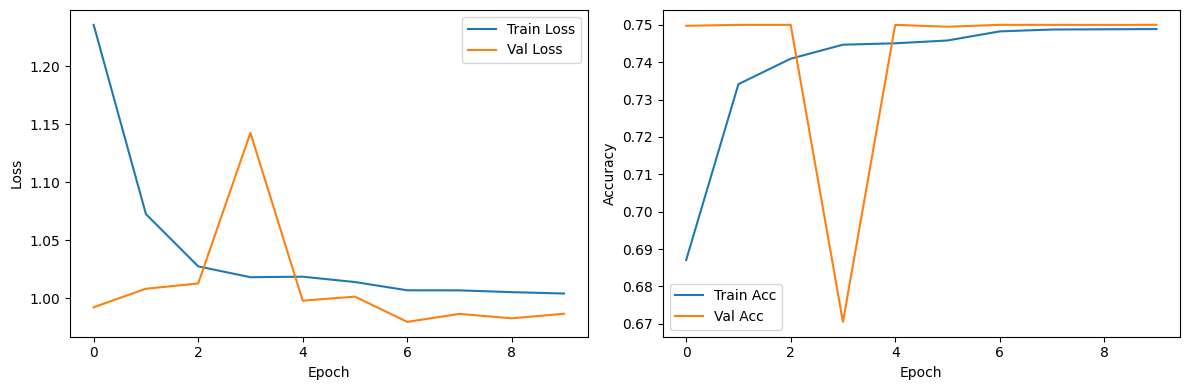

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


AttributeError: 'str' object has no attribute 'class_indices'

In [8]:
# Train and evaluate
model = create_custom_cnn()
#model.summary()


train_generator, val_generator = create_data_generators("/content/train/train", "/content/val/val")
history = train_steg_detector(model, train_generator, val_generator)
plot_history(history)

model.save('steg_detector_cnn.h5')

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

In [44]:
def evaluate_transfer_model(model, test_generator, batch_size=32, target_size=(512, 512)):

    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    # early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    class_weights = compute_class_weights(test_generator)


    # Evaluate the model
    loss, accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


    # Predict probabilities for all test images
    predictions = model.predict(test_generator)
    y_pred = np.round(predictions).flatten().astype(int)  # Convert probabilities to binary predictions (0 or 1)


    # True labels
    y_true = test_generator.classes

    # Calculate evaluation metrics
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


    print("\nClassification Report:")
    target_names = ['cover', 'stego']
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Plot ROC curve
    plot_roc_curve(y_true, predictions)

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_true, predictions)

In [45]:
import shutil
data_dir = '/content/generated_data'

ipynb_checkpoints_dir = os.path.join(data_dir, '.ipynb_checkpoints')
if os.path.exists(ipynb_checkpoints_dir):
    shutil.rmtree(ipynb_checkpoints_dir)
    print(f"Removed '{ipynb_checkpoints_dir}' directory.")


In [46]:
test_datagen = ImageDataGenerator( rescale=1./255,
        brightness_range=(0.95, 1.05),  # Subtle changes
        channel_shift_range=2  # Slight color shifts
        )
test_generator = test_datagen.flow_from_directory(
        '/content/generated_data', target_size=(512, 512), batch_size=16, class_mode='binary')

# Print class indices
print("Class Indices:", test_generator.class_indices)

Found 544 images belonging to 2 classes.
Class Indices: {'cover': 0, 'stego': 1}


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


34/34 [==============================] - 12s 349ms/step - loss: 105.8913 - accuracy: 0.3015
Test Loss: 105.8913, Test Accuracy: 0.3015
34/34 [==============================] - 12s 342ms/step
Confusion Matrix:
[[  1 380]
 [  0 163]]

Classification Report:
              precision    recall  f1-score   support

       cover       1.00      0.00      0.01       381
       stego       0.30      1.00      0.46       163

    accuracy                           0.30       544
   macro avg       0.65      0.50      0.23       544
weighted avg       0.79      0.30      0.14       544



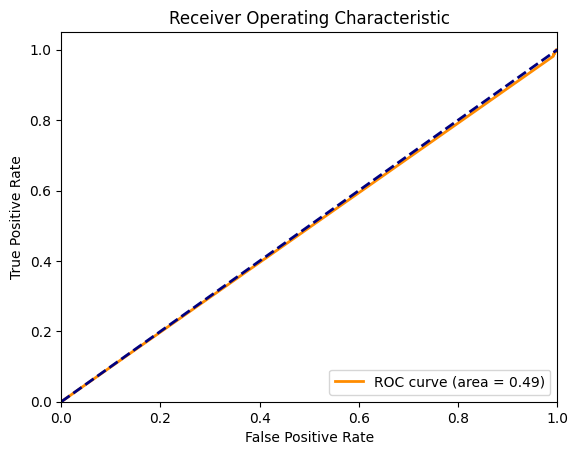

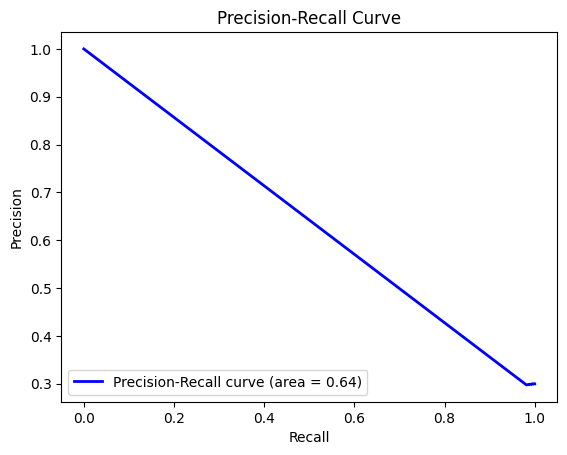

In [47]:
evaluate_transfer_model(model, test_generator)